<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/CMD_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import shutil
import subprocess
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
nruns = 50

In [ ]:
!nvidia-smi

Thu Aug 11 14:53:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [ ]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 193 (delta 121), reused 114 (delta 55), pack-reused 0
Receiving objects: 100% (193/193), 589.11 KiB | 4.99 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [ ]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl (189.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for i in range(nruns):
 base_cmd = ['python3', 'bnn_hmc/scripts/run_sgd.py', '--seed=%s' % i, '--weight_decay=10', '--dir=runs/sgd/mirabestc/lenet/%s/' % i, 
 '--dataset_name=mirabest/confident', '--model_name=lenet', '--init_step_size=3e-7', '--num_epochs=200', 
 '--eval_freq=5', '--batch_size=53', '--patience=10']
 train_cmd = base_cmd + ['--train_split=train[:80%]', '--test_split=train[80%:]']
 eval_cmd = base_cmd + ['--eval_split=test']
 print(' '.join(train_cmd))
 subprocess.run(train_cmd, capture_output=True)
 subprocess.run(eval_cmd, capture_output=True)

python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/mirabestc/lenet/0/ --dataset_name=mirabest/confident --model_name=lenet --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 --batch_size=53 --patience=10 --train_split=train[:80%] --test_split=train[80%:]
python3 bnn_hmc/scripts/run_sgd.py --seed=1 --weight_decay=10 --dir=runs/sgd/mirabestc/lenet/1/ --dataset_name=mirabest/confident --model_name=lenet --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 --batch_size=53 --patience=10 --train_split=train[:80%] --test_split=train[80%:]
python3 bnn_hmc/scripts/run_sgd.py --seed=2 --weight_decay=10 --dir=runs/sgd/mirabestc/lenet/2/ --dataset_name=mirabest/confident --model_name=lenet --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 --batch_size=53 --patience=10 --train_split=train[:80%] --test_split=train[80%:]
python3 bnn_hmc/scripts/run_sgd.py --seed=3 --weight_decay=10 --dir=runs/sgd/mirabestc/lenet/3/ --dataset_name=mirabest/confident --model_name=lenet --

In [ ]:
accuracies = []
nlls = []
eces = []
softmax = []
for i, root in enumerate(glob.glob('/content/runs/sgd/mirabestc/lenet/*/*/')):
  data = np.load(root + '/test_set.npy')  
  prediction = np.load(root + '/predictions.npy')
  metrics = np.load(root + '/metrics.npy', allow_pickle=True)
  accuracies.append(metrics.item()['accuracy'])
  nlls.append(metrics.item()['nll'])
  eces.append(metrics.item()['ece'])
  softmax.append(np.squeeze(prediction))
print('Accuracy', np.mean(accuracies), np.std(accuracies))
print('NLL', np.mean(nlls), np.std(nlls))
print('ECE', np.mean(eces), np.std(eces))
softmax = np.array(softmax)

Accuracy 0.89557695 0.018645918
NLL 0.30361935 0.036195856
ECE 0.070390984 0.014845853


In [ ]:
def uncertainty(softmax):
  # Per example softmax with shape(num_examples, num_classes)
  predictive_entropy = 0
  single_pass_entropy = 0
  for i in range(softmax.shape[1]):
    # Sum over classes
    predictive_entropy += -np.mean(softmax[:,i])*np.log(np.mean(softmax[:,i]))
    single_pass_entropy += -softmax[:,i]*np.log(softmax[:,i])
  single_pass_entropy = np.mean(single_pass_entropy)
  mutual_info = predictive_entropy - single_pass_entropy
  return predictive_entropy, single_pass_entropy, mutual_info

In [ ]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

Predictive entropy: 0.27155006662808145 0.22990705240843187
Single pass entropy: 0.24367192 0.205041
Mutual info: 0.0278781314857322 0.03316762072376633


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


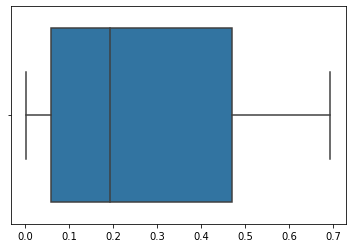

In [ ]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


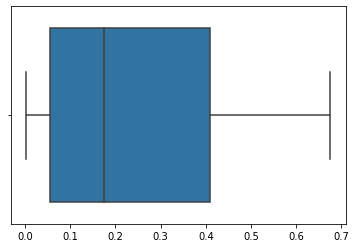

In [ ]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


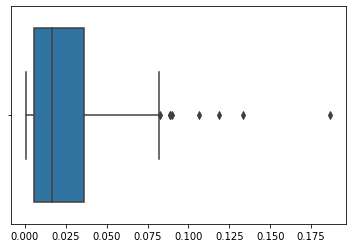

In [ ]:
sns.boxplot(mutual_infos)
plt.show()